In [7]:
from pandas_datareader.data import DataReader
import numpy as np
import plotly.graph_objs as go
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from stockstats import StockDataFrame
from sklearn.preprocessing import MinMaxScaler
from statistics import variance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras import losses
from keras.layers import LSTM, Dense, Dropout
import yfinance as yf


def predict(num_prediction, model):
    prediction_list = test_X[-2:]

    for i in range(num_prediction):
        x = prediction_list[-1:]
        out = [float(model.predict(x,verbose=0)[-1:])]
        x = x.reshape(-1)
        for var in range(n_vars-1):
            out.append(x[var+1] + x[var+1] - prediction_list[-2,0,var+1])
        prediction_list = prediction_list.reshape(i+2,prediction_list.shape[2])
        prediction_list = np.vstack([prediction_list, out])
        prediction_list = prediction_list.reshape(i+3,1,prediction_list.shape[1])
    
    return prediction_list


def predict_dates(num_prediction):
    last_date = data.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction + 1).tolist()
    prediction_dates.pop(0)
    return prediction_dates

[*********************100%%**********************]  1 of 1 completed
                Close
Date                 
1994-01-03   8.383037
1994-01-04   8.323159
1994-01-05   8.502795
1994-01-06   8.622553
1994-01-07   8.622553
...               ...
2023-09-11  63.840000
2023-09-12  66.430000
2023-09-13  66.320000
2023-09-14  67.300003
2023-09-15  66.150002

[7479 rows x 1 columns]


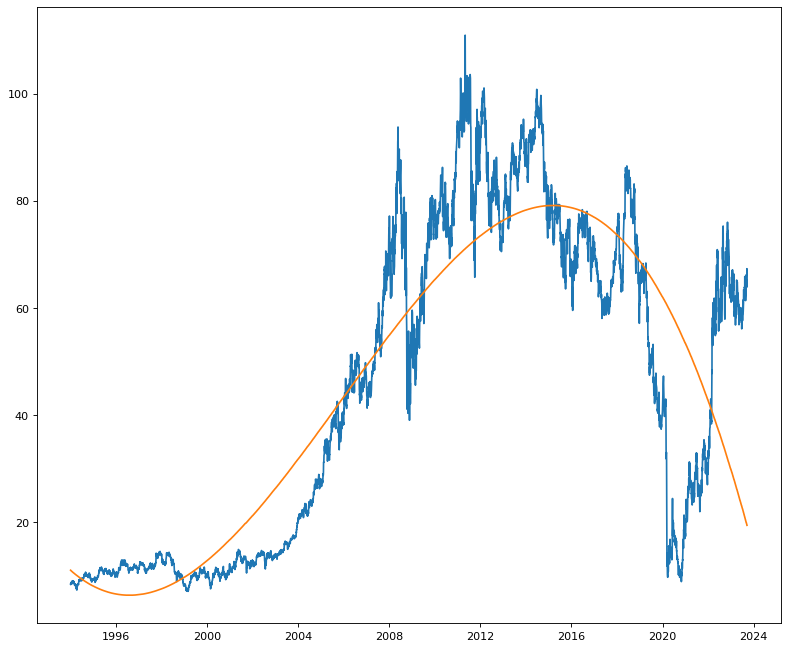

In [2]:
# user_input = input('Input the ticker:')
user_input = 'OXY'
# df = DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
start_date = '1994-01-01'  # Replace with your desired start date
end_date = '2023-09-17'  # Replace with your desired end date
df = yf.download(user_input, start=start_date, end=end_date, auto_adjust=False)
# df = DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now()- timedelta(days=5))
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
print(data)

# Convert the dataframe to a numpy array
dataset = data.values
date = data.index

date_number = np.linspace(1,len(date),len(date))
dataset = dataset.flatten()
mymodel = np.poly1d(np.polyfit(date_number, dataset, 3))
plt.figure(figsize=(12, 10), dpi=80)
plt.plot(date, dataset)
plt.plot(date, mymodel(date_number))
plt.show()

In [3]:
fold = 4
n_in=1
n_out=1
dropnan = True


close_data_df = StockDataFrame.retype(df)
close_data_df.init_all()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(close_data_df[['close','macds','macd']])

scaled_df = pd.DataFrame(scaled)
scaled_df.index = close_data_df.index
scaled_df.columns = ['close','macds','macd']

print(scaled_df.corr())
# print(scaled_df.head())

# Generating input and output sequence
# Later generate back to a function
n_vars = 1 if type(data) is list else scaled_df.shape[1]
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(scaled_df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
    cols.append(scaled_df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
supervised_df = pd.concat(cols, axis=1)
supervised_df.columns = names
# drop rows with NaN values
if dropnan:
    supervised_df.dropna(inplace=True)
supervised_df = supervised_df.drop(supervised_df.columns[-n_vars+1:], axis=1)
# return agg

#series_to_supervised(close_data_df)
# supervised_df.head()

supervised_data = supervised_df.to_numpy()

close_data = scaled_df.to_numpy()
remainder = close_data.shape[0]%5
close_data = close_data[remainder:]
close_data_df = scaled_df.drop(scaled_df.index[range(0,remainder)])
print(close_data_df)

kfold=KFold(fold)

X = supervised_data[:,0:3]
y = supervised_data[:,3:]

          close     macds      macd
close  1.000000  0.089852  0.086915
macds  0.089852  1.000000  0.949617
macd   0.086915  0.949617  1.000000
               close     macds      macd
Date                                    
1994-01-07  0.014996  0.606333  0.599015
1994-01-10  0.016149  0.606649  0.599543
1994-01-11  0.014419  0.606775  0.599230
1994-01-12  0.013842  0.606743  0.598781
1994-01-13  0.013842  0.606637  0.598458
...              ...       ...       ...
2023-09-11  0.546851  0.654138  0.648645
2023-09-12  0.571798  0.658174  0.659343
2023-09-13  0.570739  0.662969  0.666351
2023-09-14  0.580178  0.669197  0.677056
2023-09-15  0.569101  0.674280  0.677509

[7475 rows x 3 columns]


In [66]:
%%capture output

run = True
mae_list = []
forecast_list = []
num_prediction = 5
num_epochs = 10
batch_size = 8
num_trials = 10
num_repeat = 1
threshold = 10
count = 1
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=3, # how many epochs to wait before stopping
    restore_best_weights=True,
)


while run == True:
    if num_repeat == 1:
        print('Start training...\n')
    for _ in range(num_trials):
        i = 1
        for train, test in kfold.split(X,y):
            if i < 5:
                print('\n' + str(count) + '/' + str(num_repeat*num_trials) + ' trials')
                i += 1
                count += 1
                train_X, test_X = X[train],X[test]
                train_y, test_y = y[train],y[test]
                date_train, date_test = date[train], date[test]  
                train_X = train_X.reshape(-1, 1, train_X.shape[1])
                test_X  = test_X.reshape(-1, 1, test_X.shape[1])
                train_y = train_y.reshape(-1, 1, train_y.shape[1])
                test_y = test_y.reshape(-1, 1, test_y.shape[1])


                model = Sequential()
                model.add(LSTM(32,
                return_sequences=True, 
                activation='relu'))
                model.add(Dropout(0.4))
                model.add(Dense(16))

                model.add(LSTM(16,activation='relu'))
                model.add(Dropout(0.4))
                model.add(Dense(1))
#                 model.compile(optimizer='sgd', loss=losses.Huber(delta=4,reduction=losses.Reduction.SUM))
                model.compile(optimizer='adam', loss='mae')
                history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=0, validation_data=(test_X, test_y),callbacks=[early_stopping], workers=4)

                # get train_y
                train_y = train_y.reshape(train_y.shape[0],1)
                train_y = np.hstack([train_y, np.zeros(train_y.shape), np.zeros(train_y.shape)])
                train_y = scaler.inverse_transform(train_y)
                train_y = train_y[:,:1]
                train_y = train_y.reshape((-1))

                # get test_y
                test_y = test_y.reshape((test_X.shape[0], test_X.shape[1]))
                inv_testy = np.hstack([test_y,np.zeros(test_y.shape),np.zeros(test_y.shape)])
                inv_testy = scaler.inverse_transform(inv_testy)
                inv_testy = inv_testy[:,:1]
                test_y = inv_testy.reshape((-1))
                
                # Validate with test_X
                yhat = model.predict(test_X)
                yhat_df = pd.DataFrame(yhat)
                yhat_df.index = close_data_df.index[test-3]
                yhat_df.columns = ['Close']
                new_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
                inv_yhat = np.concatenate((yhat_df, new_test_X[:,1:scaled_df.shape[1]]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                prediction = inv_yhat[:,:1]
                prediction = prediction.reshape((-1))
                

                forecast = predict(num_prediction, model)
                forecast = forecast.reshape(num_prediction + 2,forecast.shape[2])
#                 forecast = np.delete(forecast,slice(scaled_df.shape[1],forecast.shape[1]),1)
                forecast = scaler.inverse_transform(forecast)
#                 forecast = np.delete(forecast,slice(1,forecast.shape[1]),1)
#                 forecast = forecast.reshape((num_prediction + 2,scaled_df.shape[1]))
                forecast = forecast[:,0]
                forecast = forecast.reshape((-1))
                print(forecast)
                forecast_list = np.append(forecast_list,np.array([forecast]))

                score = mean_absolute_error(test_y, prediction)
                mae_list.append(score)

    forecast_list = np.reshape(forecast_list,[4*num_repeat*num_trials,num_prediction + 2])
    forecasts = forecast_list[:,2:]
    forecast_5days = forecasts[:,:5]

    var_list = []
    for i in range(forecast_5days.shape[0]):
        var = variance(forecast_5days[i])
        var_list.append(var)    
    if min(var_list) > threshold:
        run = True
        print('\nRetraining...')
        num_repeat += 1
    else:
        run = False
        print(
            '\nMinimum of mae: ',min(mae_list),
            '\nAverage of mae: ',(sum(mae_list) - max(mae_list))/(len(mae_list) - 1),
            '\nMaximum of mae: ',max(mae_list)
        )

        var = np.var(forecast_5days,axis = 1)
        maxindex = np.argmax(var)
        
        for (i, item) in enumerate(forecast_5days):
            print(i, item)

        small_var_prediction = forecast_5days[var_list.index(min(var_list))]
        print('\nPrediction with smallest variance: ',small_var_prediction)
        print('mae: ',mae_list[var_list.index(min(var_list))])
        forecast_dates = predict_dates(num_prediction)
        trace1 = go.Scatter(
            x=date_train,
            y=train_y,
            mode='lines',
            name='Data'
        )
        trace2 = go.Scatter(
            x=date_test,
            y=prediction,
            mode='lines',
            name='Prediction'
        )
        trace3 = go.Scatter(
            x=date_test,
            y=test_y,
            mode='lines',
            name='Ground Truth'
        )
        layout = go.Layout(
            title="Stock",
            xaxis={'title': "Date"},
            yaxis={'title': "Close"}
        )
        trace4 = go.Scatter(
            x=forecast_dates,
            y=small_var_prediction,
            mode='lines',
            name='Future Prediction'
        )
        fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
        fig.show()

        small_mae_prediction = forecast_5days[mae_list.index(min(mae_list))]
        print('\nPrediction with best mae: ',small_mae_prediction)
        print('mae: ',min(mae_list))

        trace4 = go.Scatter(
            x=forecast_dates,
            y=small_mae_prediction,
            mode='lines',
            name='Future Prediction'
        )
        fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
        fig.show()

2023-09-24 22:49:49.600937: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false

2023-09-24 22:49:55.448735: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false

2023-09-24 22:50:15.249091: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false

2023-09-24 22:50:16.145332: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_

In [67]:
# # actual_df =  DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now()- timedelta(days=5))
# # actual_df =  DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
# actual_df = yf.download(user_input, start=start_date, end=end_date, auto_adjust=False)
# actual_price = actual_df.filter(['Close'])
# actual = actual_price[-5:]
# print(actual)

In [68]:
# back_mae_list = []
# for i in range(forecast_5days.shape[0]):
#     back_mae = mean_absolute_error(forecast_5days[i], actual)
#     back_mae_list.append(back_mae)

# best_fit = forecast_list[back_mae_list.index(min(back_mae_list))]
# prediction = best_fit[

# print('\nmy choice: ',best_fit)
# trace4 = go.Scatter(
#     x=forecast_dates,
#     y=best_fit,
#     mode='lines',
#     name='Future Prediction'
# )
# fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
# fig.show()

# forecast_score = mean_absolute_error(my_choice,actual)
# print('mae: ',forecast_score)

<Axes: >

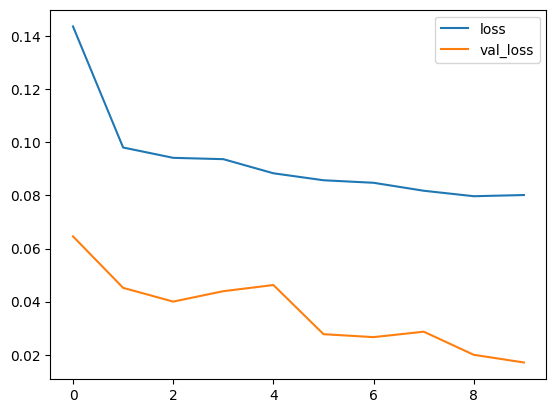

In [69]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [73]:
# score for forecast
# actual_df =  DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now()- timedelta(days=5))
# actual_df =  DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
actual_df = yf.download(user_input, start=start_date, end=end_date, auto_adjust=False)
actual_price = actual_df.filter(['Close'])
actual = actual_price[-5:]
print(actual)

# my_choice = forecast_5days[0]
my_choice = small_mae_prediction

print('\nmy choice: ',my_choice)
trace4 = go.Scatter(
    x=forecast_dates,
    y=my_choice,
    mode='lines',
    name='Future Prediction'
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()

forecast_score = mean_absolute_error(my_choice,actual)
print('mae: ',forecast_score)

[*********************100%%**********************]  1 of 1 completed
                Close
Date                 
2023-09-11  63.840000
2023-09-12  66.430000
2023-09-13  66.320000
2023-09-14  67.300003
2023-09-15  66.150002

my choice:  [68.22510818 69.00385891 69.63376551 70.1205582  70.47559849]


mae:  3.4837769108899237


In [74]:
# score for forecast
# actual_df =  DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
actual_df = yf.download(user_input, start=start_date, end=end_date, auto_adjust=False)
actual_price = actual_df.filter(['Close'])
actual = actual_price[-5:]
print(actual)

# seleted_forecast = forecast_5days[3]
# seleted_forecast = seleted_forecast.reshape(5,1)
# seleted_forecast = [143.69,144.59,146.14,148.19,150.65]
# seleted_forecast = [148.95,148.17,147.25,146.42,146.37]
print('\nForecast 5 days:\n',small_var_prediction)
forecast_score = mean_absolute_error(small_var_prediction,actual)
print('mae: ',forecast_score)
print('\nForecast 5 days:\n',small_mae_prediction)
forecast_score = mean_absolute_error(small_mae_prediction,actual)
print('mae: ',forecast_score)

[*********************100%%**********************]  1 of 1 completed
                Close
Date                 
2023-09-11  63.840000
2023-09-12  66.430000
2023-09-13  66.320000
2023-09-14  67.300003
2023-09-15  66.150002

Forecast 5 days:
 [51.55394817 51.52365706 51.5533046  51.62003477 51.70815127]
mae:  14.416181773999904

Forecast 5 days:
 [68.22510818 69.00385891 69.63376551 70.1205582  70.47559849]
mae:  3.4837769108899237


In [75]:
# 32:1.7
# 64:1.7